In [1]:
# !pip install pandas_datareader


In [76]:
from dotenv import load_dotenv
import os

load_dotenv()
key = os.getenv("API_KEY")


In [77]:
import pandas_datareader.data as pdr #data collection

In [78]:
df=pdr.get_data_tiingo('AAPL',api_key=key)

In [79]:
# df.to_csv('AAPL.csv')

In [80]:
df1=df.reset_index()['close']

In [81]:
df1.shape

(1255,)

In [82]:
df1

0       388.00
1       389.09
2       371.38
3       370.46
4       379.24
         ...  
1250    208.62
1251    209.11
1252    210.16
1253    210.02
1254    211.18
Name: close, Length: 1255, dtype: float64

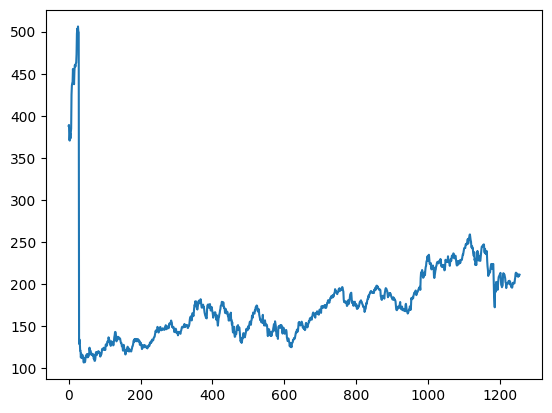

In [83]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [84]:
## LSTM are very sensitive to the scale of the data. so we apply minmax scaler

In [85]:
import numpy as np

In [86]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [87]:
# --- ADD THIS LINE TO SAVE THE SCALER ---
import joblib
joblib.dump(scaler, 'my_scaler.pkl')
print("Scaler saved successfully as 'my_scaler.pkl'")

Scaler saved successfully as 'my_scaler.pkl'


In [88]:
df1.shape

(1255, 1)

In [89]:
print(df1)

[[0.70422041]
 [0.70695053]
 [0.66259236]
 ...
 [0.25878522]
 [0.25843456]
 [0.26134001]]


In [90]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65) #65%
test_size=len(df1)-training_size  #35%
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [91]:
training_size,test_size

(815, 440)

In [92]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [93]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [94]:
print(X_train)

[[0.70422041 0.70695053 0.66259236 ... 0.04235441 0.04393237 0.03742016]
 [0.70695053 0.66259236 0.66028804 ... 0.04393237 0.03742016 0.04107702]
 [0.66259236 0.66028804 0.68227927 ... 0.03742016 0.04107702 0.03899812]
 ...
 [0.16493425 0.17084534 0.17112085 ... 0.17049468 0.17695679 0.18071384]
 [0.17084534 0.17112085 0.16871634 ... 0.17695679 0.18071384 0.17921102]
 [0.17112085 0.16871634 0.16210394 ... 0.18071384 0.17921102 0.18274264]]


In [95]:
print(X_train.shape,"\n",y_train.shape)

(714, 100) 
 (714,)


In [96]:
print(X_test.shape,"\n",ytest.shape)

(339, 100) 
 (339,)


In [97]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [98]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [99]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

C:\Users\Lenovo\Abhay_Everything\Stock Price Prediction\Stock Price project\Stock-price-prediction\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [100]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 100, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 100, 50)             │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [101]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 100, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 100, 50)             │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [102]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 375ms/step - loss: 0.0069 - val_loss: 0.0133
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - loss: 0.0011 - val_loss: 0.0039
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - loss: 5.6156e-04 - val_loss: 9.7638e-04
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step - loss: 4.1384e-04 - val_loss: 9.2219e-04
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - loss: 3.5898e-04 - val_loss: 6.5808e-04
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - loss: 3.3868e-04 - val_loss: 8.8996e-04
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 332ms/step - loss: 3.0778e-04 - val_loss: 6.0190e-04
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - loss: 3.1931e-04 - val_loss: 5.8060e-04
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 258ms/step - loss: 2.8201e-04 - val_loss: 7.4593e-04
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 270ms/step - loss: 2.8348e-04 - val_loss: 7.5843e-04
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step - loss: 2.

In [103]:
# After your model.fit(X_train, y_train, ...) call
# For example, if your model object is named 'model'
model.save('my_lstm_model.h5')
print("Model saved successfully as 'my_lstm_model.h5'")

Model saved successfully as 'my_lstm_model.h5'


In [104]:
import tensorflow as tf

In [105]:
tf.__version__

'2.19.0'

In [106]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


In [107]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.009171803678760903

In [108]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

0.012833256487367132

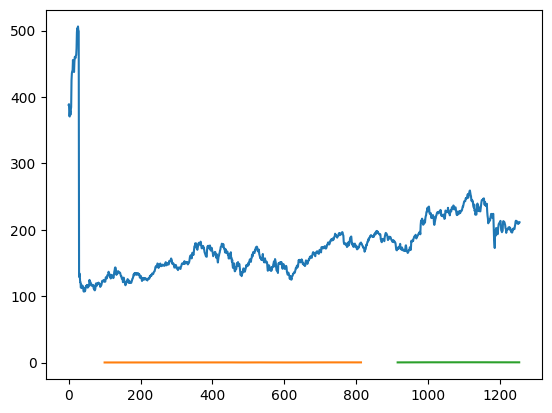

In [109]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [110]:
len(test_data)

440

In [111]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 99)

In [112]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [113]:
temp_input

[0.3344270507201002,
 0.326762680025047,
 0.3381340012523481,
 0.32859110832811517,
 0.323331246086412,
 0.3228553537883531,
 0.3218284283030682,
 0.331195992485911,
 0.30216656230432054,
 0.28553537883531616,
 0.2758672510958045,
 0.2575829680651221,
 0.26712586098935504,
 0.26840325610519716,
 0.2651221039448966,
 0.2715090795241077,
 0.26865372573575447,
 0.27909830932999374,
 0.28525986224170313,
 0.29282404508453347,
 0.28726361928616145,
 0.2930745147150908,
 0.2781715716969317,
 0.2887664370695053,
 0.29142141515341263,
 0.29317470256731365,
 0.2413274890419536,
 0.20423293675641824,
 0.18690043832185343,
 0.16425798371947392,
 0.230457107075767,
 0.20934251721978703,
 0.22870381966186598,
 0.23964934251721975,
 0.23869755792110198,
 0.21898559799624295,
 0.2257733249843456,
 0.21620538509705695,
 0.23268628678772701,
 0.24485911083281148,
 0.25430181590482154,
 0.2565810895428929,
 0.25873512836568563,
 0.2614151534126487,
 0.2646462116468378,
 0.2667000626174076,
 0.2467376330

In [118]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

0 day input [0.20934252 0.22870382 0.23964934 0.23869756 0.2189856  0.22577332
 0.21620539 0.23268629 0.24485911 0.25430182 0.25658109 0.25873513
 0.26141515 0.26464621 0.26670006 0.24673763 0.23055729 0.22960551
 0.2239449  0.22705072 0.2296556  0.26036318 0.26572323 0.26422041
 0.26201628 0.26154039 0.25532874 0.25051972 0.23857232 0.23674389
 0.22149029 0.23386349 0.23438948 0.23321227 0.2354665  0.23759549
 0.24152786 0.24040075 0.23491547 0.24315592 0.23696932 0.24002505
 0.23028178 0.23133375 0.22444584 0.22938009 0.22241703 0.22477145
 0.2358422  0.23709455 0.23408892 0.23724483 0.2358422  0.23604258
 0.24628679 0.25292423 0.26449593 0.26727614 0.25825924 0.25840952
 0.26123982 0.26442079 0.26128992 0.25492799 0.25615529 0.25878522
 0.25843456 0.26134001 0.26117235 0.26117235 0.2642633  0.26542512
 0.26665205 0.26781559 0.26885173 0.26975504 0.27054918 0.2712675
 0.27194414 0.27260849 0.27328357 0.27398413 0.27471709 0.27548245
 0.27627498 0.27708641 0.27790678 0.27872655 0.2795

In [115]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [119]:
import matplotlib.pyplot as plt

In [120]:
len(df1)

1255

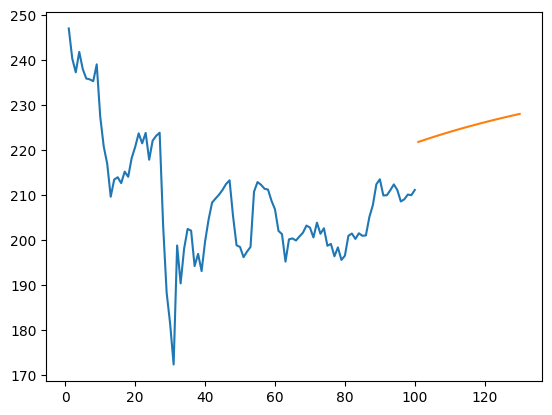

In [121]:
plt.plot(day_new,scaler.inverse_transform(df1[1155:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

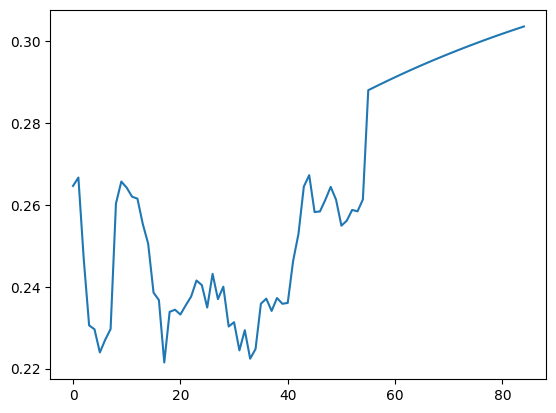

In [122]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [123]:
df3=scaler.inverse_transform(df3).tolist()

In [126]:
plt.plot(df3)